In [164]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

words = open('names.txt','r').read().split('\n')

chars = sorted(list(set(''.join(words))))
S_I = {c:i+1 for i,c in enumerate(chars)}
S_I['.'] = 0
I_S = {i:c for c,i in S_I.items()}
block_size = 3  # context size
vocab_size = len(S_I)
def build_dataset(words):
    # build the dataset
   

    X,Y = [],[] # input, labels
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = S_I[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.Tensor(X).long()
    Y = torch.Tensor(Y).long()
    print(X.shape,Y.shape)
    return X,Y

# split into train val and test
random.seed(42)
random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

X_train,Y_train = build_dataset(words[:n1])  #train network
X_val,Y_val = build_dataset(words[n1:n2])    # tune hyperparameters
X_test,Y_test = build_dataset(words[n2:])    # final evaluation

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [165]:
# the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [166]:
# Network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [167]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.2870
  10000/ 200000: 2.3273
  20000/ 200000: 2.1019
  30000/ 200000: 1.9020
  40000/ 200000: 2.1643
  50000/ 200000: 2.1520
  60000/ 200000: 1.7767
  70000/ 200000: 2.1514
  80000/ 200000: 2.3802
  90000/ 200000: 1.9338
 100000/ 200000: 2.3943
 110000/ 200000: 2.1508
 120000/ 200000: 2.1813
 130000/ 200000: 2.0889
 140000/ 200000: 1.8096
 150000/ 200000: 1.9132
 160000/ 200000: 1.9793
 170000/ 200000: 1.9654
 180000/ 200000: 2.2462
 190000/ 200000: 1.9601


Text(0.5, 1.0, 'Histogram of activations')

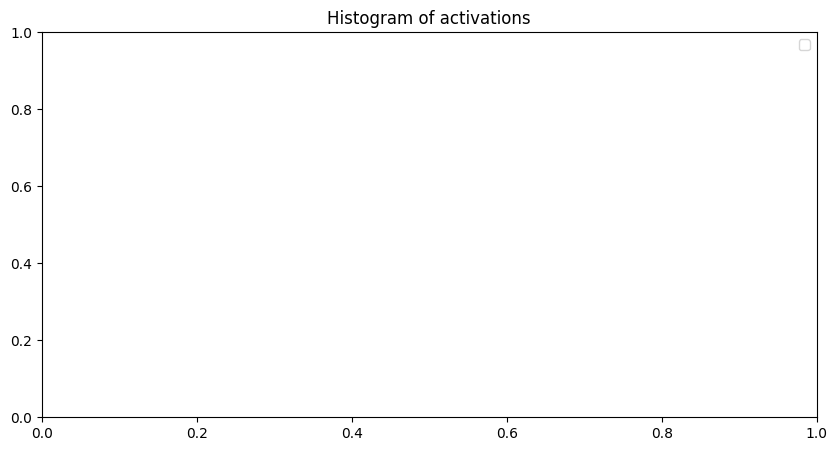

In [168]:
#visualize 
plt.figure(figsize=(10,5))
legend = []
for i,layer in enumerate(layers[:-1]): # exclude last layer
    if isinstance(layers,Tanh):
        t= layer.out
        print('layer %d: mean %.2f std %.2f saturation %.2f%%' % (i,t.mean(),t.std(),(abs(t)>.97).float().mean()*100))
        hy, hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legend.append(f'layer {i}  {layer.__class__.__name__}')
plt.legend(legend)
plt.title('Histogram of activations')
# check if activations are saturated

layer 2 grad: mean 0.00 std 0.00 saturation 0.00%
layer 5 grad: mean 0.00 std 0.00 saturation 0.00%
layer 8 grad: mean 0.00 std 0.00 saturation 0.00%
layer 11 grad: mean -0.00 std 0.00 saturation 0.00%
layer 14 grad: mean -0.00 std 0.00 saturation 0.00%


Text(0.5, 1.0, 'Mean gradient magnitude')

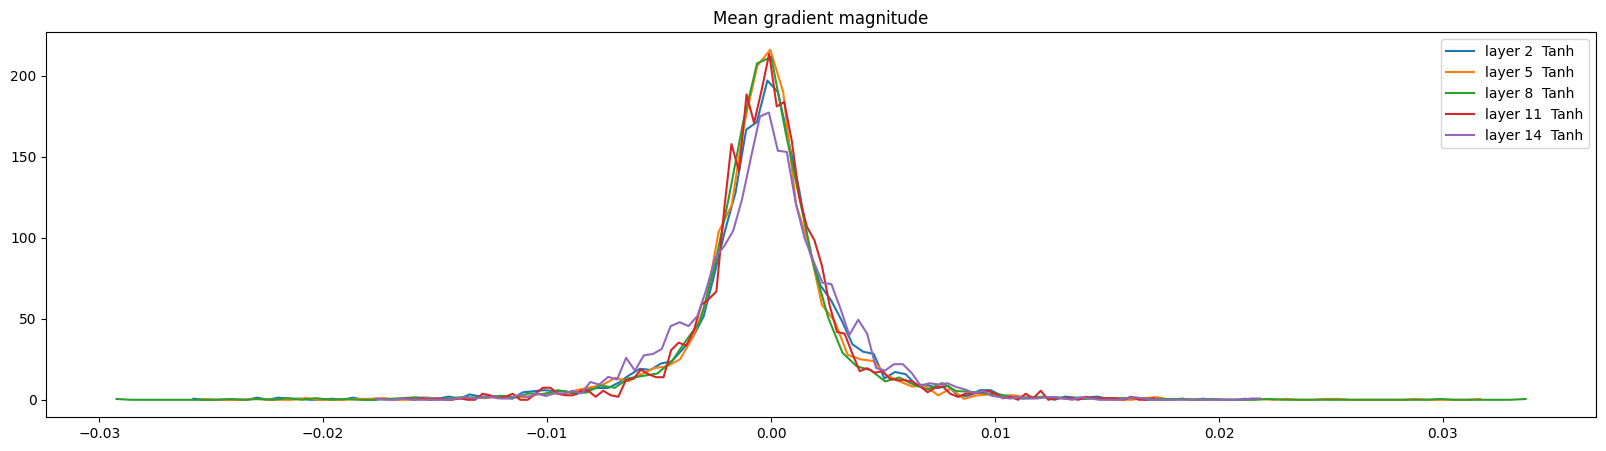

In [169]:
# visualize gradients
plt.figure(figsize=(20,5))
legend = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t= layer.out.grad
        print('layer %d grad: mean %.2f std %.2f saturation %.2f%%' % (i,t.mean(),t.std(),(abs(t)>.97).float().mean()*100))
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legend.append(f'layer {i}  {layer.__class__.__name__}')
plt.legend(legend)
plt.title('Mean gradient magnitude')

weight torch.Size([27, 10]) mean 1.103790e-10 std 1.841464e-02  grad_data_ratio 1.484899e-01
weight torch.Size([30, 100]) mean -4.357017e-05 std 9.194417e-03  grad_data_ratio 5.015604e-01
weight torch.Size([100, 100]) mean 4.817421e-05 std 5.665645e-03  grad_data_ratio 3.518549e+00
weight torch.Size([100, 100]) mean 3.284462e-05 std 5.441619e-03  grad_data_ratio 6.433717e+00
weight torch.Size([100, 100]) mean 4.715861e-05 std 5.277538e-03  grad_data_ratio 1.787074e+03
weight torch.Size([100, 100]) mean 1.400871e-06 std 4.858477e-03  grad_data_ratio 8.152901e-01
weight torch.Size([100, 27]) mean -8.206622e-05 std 7.756827e-03  grad_data_ratio 8.869632e-01


Text(0.5, 1.0, 'weight gradient magnitude')

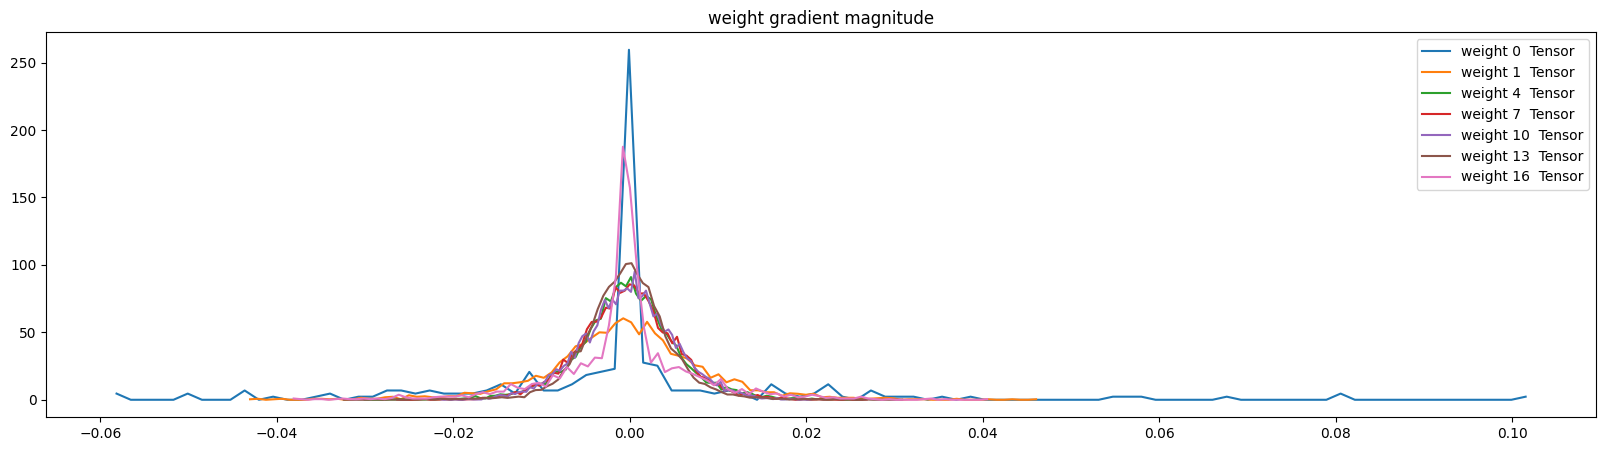

In [170]:
# parameters
plt.figure(figsize=(20,5))
legend = []
for i,p in enumerate(parameters):
    t= p.grad
    if p.ndim == 2:
        print('weight %10s mean %e std %e  grad_data_ratio %e' % (p.shape,t.mean(),t.std(),(t/p).std()))
        hy,hx= torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legend.append(f'weight {i}  {p.__class__.__name__}')
plt.legend(legend)
plt.title('weight gradient magnitude')

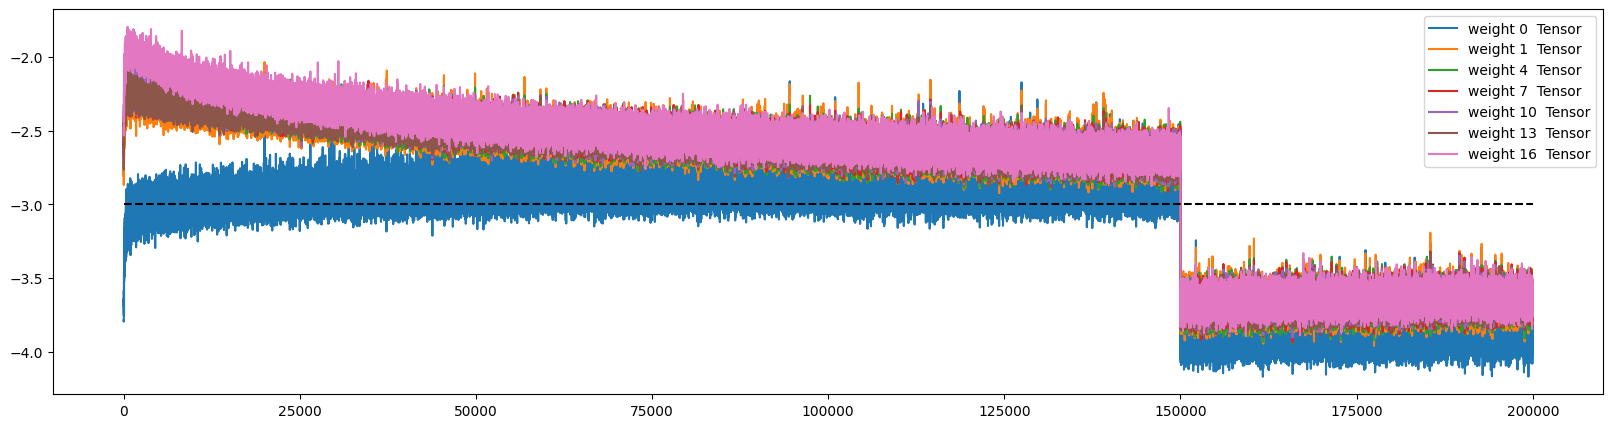

In [171]:
plt.figure(figsize=(20,5))
legend = []
for i,p in enumerate(parameters):
    t= p.grad
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))]) 
        legend.append(f'weight {i}  {p.__class__.__name__}')
plt.plot([0,len(ud)],[-3,-3],'k--') # should be around -3
plt.legend(legend)
# check if learning rate is too high or too low

In [172]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.999863624572754
val 2.077087879180908


In [173]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(I_S[i] for i in out)) # decode and print the generated word

montaylynn.
see.
mad.
rylla.
emmasiendra.
gradee.
daelin.
shi.
jenneden.
estanaraelyn.
malaia.
nosalbergiaghiel.
kinjo.
jennix.
teriffuna.
geder.
yarun.
eli.
kayshaykella.
halisa.
